<a href="https://colab.research.google.com/github/mchivuku/deep-learning-e533/blob/master/Homework_3_Network_Compression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Assignment 3 - Network Compression Using SVD 

In [0]:
%%capture
!pip install tqdm six


!pip install bokeh
!pip install tensorboard
!pip install livelossplot

!pip install tensorboard



## Connect to Google Drive

In [2]:
from google.colab import drive

drive.mount("/content/drive")




Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
%cd /content/drive/My\ Drive/Masters-DS/Deep\ Learning\ -\ E533/Homework3



/content/drive/My Drive/Masters-DS/Deep Learning - E533/Homework3


In [0]:
#content/drive/My Drive/Masters-DS/Deep Learning - E533/MNIST


## Import Libraries

In [3]:
from glob import glob
import os
import numpy as np
import matplotlib.pyplot as plt
import shutil
from torchvision import transforms
from torchvision import models
import torchvision
import torch
from torch.autograd import Variable
import torch.nn as nn
from torch.optim import lr_scheduler
from torch import optim
from torchvision.datasets import ImageFolder
from torchvision.utils import make_grid
import time
from torchvision import datasets,transforms
import torch.nn.functional as F
import torch.optim as optim


import os

## Plotting library

from bokeh.plotting import figure
from bokeh.io import show
from bokeh.models import LinearAxis, Range1d
from livelossplot import PlotLosses


plt.style.use('ggplot')

print('Torch', torch.__version__, 'CUDA', torch.version.cuda)
print('Device:', torch.device('cuda:0'))
print(torch.cuda.is_available())

is_cuda = torch.cuda.is_available()
device = torch.device ( "cuda:0" if torch.cuda.is_available () else "cpu" )

Torch 1.0.1.post2 CUDA 10.0.130
Device: cuda:0
True


## Helpers functions

In [4]:
## Show image
def imshow(img,title=None):
  """Imshow for Tensor."""
  img = img.numpy().transpose((1,2,0))
  mean = np.array([0.485, 0.456, 0.406])
  std = np.array([0.229, 0.224, 0.225])
  img = std * img + mean # normalize
  img = np.clip(img, 0, 1) # clip image
  plt.figure(figsize=(16,4))
  plt.axis('off')
  plt.imshow(img)
  
  if title is not None:
    plt.title(title)         
  
def plot_grid(inputs, classes):
  # Make a grid from batch 
  out = torchvision.utils.make_grid(inputs,10,10)
  imshow(out, title="")
  print([class_names[x] for x in classes])
  
  
  
def plot_loss(y, title):
  plt.figure()
  plt.plot(y)
  plt.title(title)
  plt.xlabel('epochs')
  plt.ylabel('Loss')
  
def plot_accuracy(y, title):
  plt.figure()
  plt.plot(y)
  plt.title(title)
  plt.xlabel('epochs')
  plt.ylabel('accuracy')
  
  
%cd /content/drive/My\ Drive/Masters-DS/Deep\ Learning\ -\ E533/Homework3

/content/drive/My Drive/Masters-DS/Deep Learning - E533/Homework3


In [0]:

path=""

transformation = transforms.Compose([transforms.ToTensor(),transforms.Normalize((0.1307,), (0.3081,))])
train_dataset = datasets.MNIST(os.path.join(path,"MNIST/data"),train=True,transform=transformation,download=True)
test_dataset = datasets.MNIST(os.path.join(path,"MNIST/data"),train=False,transform=transformation,download=True)
train_loader = torch.utils.data.DataLoader(train_dataset,batch_size=128,shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset,batch_size=128,shuffle=True)


## Train a fully -connected net for MNIST classification. It should be a with 5 hidden layers each of which is with 1024 hidden units. Feel free to use what ever techniques learnt in clas. 

['1 - one', '0 - zero', '6 - six', '2 - two', '0 - zero', '5 - five', '0 - zero', '7 - seven', '0 - zero', '4 - four', '8 - eight', '4 - four', '1 - one', '2 - two', '1 - one', '2 - two', '8 - eight', '3 - three', '1 - one', '1 - one', '2 - two', '4 - four', '9 - nine', '6 - six', '8 - eight', '8 - eight', '6 - six', '1 - one', '3 - three', '6 - six', '0 - zero', '0 - zero', '8 - eight', '0 - zero', '1 - one', '9 - nine', '6 - six', '2 - two', '7 - seven', '1 - one', '7 - seven', '4 - four', '2 - two', '4 - four', '0 - zero', '3 - three', '5 - five', '4 - four', '1 - one', '8 - eight', '1 - one', '3 - three', '0 - zero', '0 - zero', '4 - four', '2 - two', '5 - five', '1 - one', '2 - two', '3 - three', '7 - seven', '5 - five', '0 - zero', '5 - five', '7 - seven', '5 - five', '8 - eight', '6 - six', '8 - eight', '7 - seven', '2 - two', '0 - zero', '0 - zero', '5 - five', '7 - seven', '8 - eight', '8 - eight', '4 - four', '7 - seven', '1 - one', '0 - zero', '6 - six', '4 - four', '4 - fou

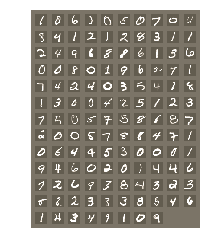

In [6]:
class_names = ['0 - zero', '1 - one', '2 - two', '3 - three', '4 - four',
               '5 - five', '6 - six', '7 - seven', '8 - eight', '9 - nine']
inputs, classes = next(iter(train_loader))
plot_grid(inputs, classes)

## Tensor Board Utilities

In [0]:
import tensorflow as tf
import numpy as np
import scipy.misc 
from PIL import Image 
try:
    from StringIO import StringIO  # Python 2.7
except ImportError:
    from io import BytesIO         # Python 3.x

## Import tensor flow library
class TensorBoardLogger(object):
  
  """
  Initialize the summary writer
  """
  def __init__(self, log_dir):
    "create summary writer"
    self.writer = tf.summary.FileWriter(log_dir)
  
  """
  Add scalar
  """
  def scalar_summary(self, tag, value, step):
    summary = tf.Summary(value=[tf.Summary.Value(tag=tag, simple_value=value)])
    self.writer.add_summary(summary,step)
    
  """
  Add images
  """
  def image_summary(self, tag, images, step):
    """Log a list of images."""

    img_summaries = []
    for i, img in enumerate(images):
        s = BytesIO()
        
        new_p = Image.fromarray(img)
        if new_p.mode != 'L':
          new_p = new_p.convert('L')
    
        new_p.save(s, format="png")

        # Create an Image object
        img_sum = tf.Summary.Image(encoded_image_string=s.getvalue(),
                                   height=img.shape[0],
                                   width=img.shape[1])
        # Create a Summary value
        img_summaries.append(tf.Summary.Value(tag='%s/%d' % (tag, i), image=img_sum))

    # Create and write Summary
    summary = tf.Summary(value=img_summaries)
    self.writer.add_summary(summary, step)
        
  def histo_summary(self, tag, values, step, bins=1000):
      """Log a histogram of the tensor of values."""

      # Create a histogram using numpy
      counts, bin_edges = np.histogram(values, bins=bins)

      # Fill the fields of the histogram proto
      hist = tf.HistogramProto()
      hist.min = float(np.min(values))
      hist.max = float(np.max(values))
      hist.num = int(np.prod(values.shape))
      hist.sum = float(np.sum(values))
      hist.sum_squares = float(np.sum(values**2))

      # Drop the start of the first bin
      bin_edges = bin_edges[1:]

      # Add bin edges and counts
      for edge in bin_edges:
          hist.bucket_limit.append(edge)
      for c in counts:
          hist.bucket.append(c)

      # Create and write Summary
      summary = tf.Summary(value=[tf.Summary.Value(tag=tag, histo=hist)])
      self.writer.add_summary(summary, step)
      self.writer.flush()

### Logging

In [96]:
LOG_DIR = '/content/drive/My\ Drive/Masters-DS/Deep\ Learning\ -\ E533/Homework3/problem1/logs/'
get_ipython().system_raw(
    'tensorboard --logdir {} --host 0.0.0.0 --port 6006 &'
    .format(LOG_DIR)
)


! wget https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
! unzip ngrok-stable-linux-amd64.zip
get_ipython().system_raw('./ngrok http 6006 &')
! curl -s http://localhost:4040/api/tunnels | python3 -c \
    "import sys, json; print(json.load(sys.stdin)['tunnels'][0]['public_url'])"

--2019-03-11 17:08:32--  https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
Resolving bin.equinox.io (bin.equinox.io)... 52.22.236.254, 52.2.175.150, 52.22.145.207, ...
Connecting to bin.equinox.io (bin.equinox.io)|52.22.236.254|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 14893410 (14M) [application/octet-stream]
Saving to: ‘ngrok-stable-linux-amd64.zip.11’

ngrok-stable-linux- 100%[===================>]  14.20M  42.3MB/s    in 0.3s    

2019-03-11 17:08:33 (42.3 MB/s) - ‘ngrok-stable-linux-amd64.zip.11’ saved [14893410/14893410]

Archive:  ngrok-stable-linux-amd64.zip
replace ngrok? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: ngrok                   
http://073d4958.ngrok.io


## Compute Running Average for the losses or accuracy

In [0]:
class RunningAverage ():
    """A simple class that maintains the running average of a quantity
    Example:
    ```
    loss_avg = RunningAverage()
    loss_avg.update(2)
    loss_avg.update(4)
    loss_avg() = 3
    ```
    """

    def __init__( self ):
        self.steps = 0
        self.total = 0

    def update( self, val ):
        self.total += val
        self.steps += 1

    def __call__( self ):
        return self.total / float ( self.steps )


## Simple CNN

In [10]:
class Net(nn.Module):
  def __init__(self):
    super(Net,self).__init__()
    
    ## Define NN - 5 hidden layers 1024 hidden units
    self.fc1 = nn.Linear(784, 1024)
    self.fc2 = nn.Linear(1024, 1024)
    self.fc3 = nn.Linear(1024, 1024)
    self.fc4 = nn.Linear(1024, 1024)
    self.fc5 = nn.Linear(1024, 1024)
    self.fc6 = nn.Linear(1024, 10)
    
  
  def forward(self,x):
    ## flat input features
    x = x.view(-1, self.num_flat_features(x))
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    x = F.relu(self.fc3(x))
    x = F.relu(self.fc4(x))
    x = F.relu(self.fc5(x))
    x = self.fc6(x)
    
    return F.log_softmax(x, dim=1)  
  
  def num_flat_features(self,x):
    size = x.size()[1:] # all dimensions except the batch dimension
    num_features = 1
    for s in size:
      num_features *=s
    return num_features
    
    
model = Net()
if is_cuda:
    model.cuda()
    
## 5 hidden layers 
print(model)

Net(
  (fc1): Linear(in_features=784, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=1024, bias=True)
  (fc3): Linear(in_features=1024, out_features=1024, bias=True)
  (fc4): Linear(in_features=1024, out_features=1024, bias=True)
  (fc5): Linear(in_features=1024, out_features=1024, bias=True)
  (fc6): Linear(in_features=1024, out_features=10, bias=True)
)


In [0]:
## Adam Optimizer 
import torch.optim as optim

# Loss and optimizer
learning_rate = 0.001
momemtum = 0.9

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

## Decay learning rate by a factor of 0.1 every  7 epochs
from torch.optim import lr_scheduler

exp_lr_scheduler = lr_scheduler.StepLR(optimizer,step_size = 7,gamma = 0.1)
logger = TensorBoardLogger("./problem1/logs") 

num_epochs = 10

### Train

In [0]:

### Training
def train(model, criterion, optimizer):
  model.train()
  running_loss = []
  running_corrects = 0
  total_step = len(train_loader)
  
  loss_avg = RunningAverage ()
  train_accuracy = RunningAverage()
  
  for i, (inputs, labels) in enumerate(train_loader):
    if is_cuda:
      inputs,labels = inputs.cuda(),labels.cuda()
        
    inputs, labels = Variable(inputs), Variable(labels)
    
    # Run the forward pass
    outputs = model(inputs)
    loss = criterion(outputs, labels)
    loss_avg.update(loss.item())
    
    # Backprop and perform Adam optimisation
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    # Track the accuracy
    _, argmax = torch.max(outputs, 1)
    accuracy = (labels == argmax.squeeze()).float().mean()
    train_accuracy.update(accuracy)
    
    ## average accuracy and loss per epoch
  return train_accuracy(), loss_avg(), inputs
   

In [13]:
## Build Model 
train_acc = []
train_loss = []

model.train()
def build_model(model, criterion, optimizer,num_epochs):
  for step in range(num_epochs):
    
    accuracy, loss, images = train(model, criterion, optimizer) 
    train_acc.append(accuracy)
    train_loss.append(loss)
    
    if (step+1) % 2 == 0:
      print ('Step [{}/{}], Loss: {:.4f}, Acc: {:.2f}'.format(step+1, num_epochs, loss, accuracy))

      # 1. Log scalar values (scalar summary)
      info = { 'loss': loss, 'accuracy': accuracy }

      for tag, value in info.items():
          logger.scalar_summary(tag, value, step+1)

      # 2. Log values and gradients of the parameters (histogram summary)
      for tag, value in model.named_parameters():
          tag = tag.replace('.', '/')
          logger.histo_summary(tag, value.data.cpu().numpy(), step+1)
          logger.histo_summary(tag+'/grad', value.grad.data.cpu().numpy(), step+1)

      # 3. Log training images (image summary)
      info = { 'images': images.view(-1, 28, 28)[:10].cpu().numpy() }

      #for tag, images in info.items():
       #   logger.image_summary(tag, images, step+1)
      
     

    
build_model(model,criterion, optimizer,num_epochs)


Step [2/10], Loss: 0.1171, Acc: 0.97
Step [4/10], Loss: 0.0700, Acc: 0.98
Step [6/10], Loss: 0.0528, Acc: 0.99
Step [8/10], Loss: 0.0395, Acc: 0.99
Step [10/10], Loss: 0.0281, Acc: 0.99


Text(0.5, 1.0, 'MNIST Train accuracy')

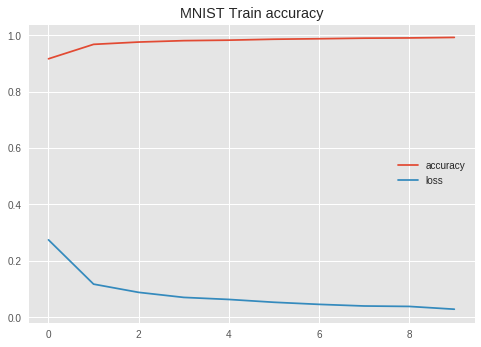

In [14]:
import numpy as np
plt.plot(np.arange(num_epochs), train_acc)
plt.plot(np.arange(num_epochs),train_loss)
plt.legend(["accuracy","loss"])
plt.title("MNIST Train accuracy")

### Test Model

In [15]:
# Test the model
# In test phase, we don't need to compute gradients (for memory efficiency)
#liveloss_test = PlotLosses()

model.eval()
with torch.no_grad():
    correct = 0
    total = 0
    batch_correct = 0
    test_accuracy = RunningAverage()
    for step, (images, labels) in enumerate(test_loader):
        batch_correct = 0
        images = images.to(device)
        labels = labels.to(device)
        
        outputs = model(images)
        values, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        batch_correct += (predicted == labels).sum().item()
                
        correct+=batch_correct
        # 1. Log scalar values (scalar summary)
        info = {'accuracy': batch_correct }
        
        for tag, value in info.items():
          logger.scalar_summary(tag, value, step+1)
        
        # 2. Log test images (image summary)
        info = { 'test_predictions_images': images.view(-1, 28, 28)[:1000].cpu().numpy() }
        
        for tag, images in info.items():
          logger.image_summary(tag, images, step+1)
          
        #liveloss_test.update({
        #'test accuracy': (100 * correct / total),
        #})
        test_accuracy.update(batch_correct/labels.size(0))
    #liveloss_test.draw()
     
    print('Accuracy of the network on the 10000 test images: {} %'.format(100*test_accuracy()))

    

Accuracy of the network on the 10000 test images: 98.23971518987342 %


## SVD

In [0]:
svd = lambda weights: torch.svd(weights)
get_d_w_matrix = lambda U,S,V,D: torch.mm(U[:,:D], torch.mm(S[:D].diag(), V[:,:D].t()))




layer1 = (list(model.fc1.named_parameters()))
layer1_Weights = layer1[0][1]

layer2 = (list(model.fc2.named_parameters()))
layer2_Weights = layer2[0][1]

layer3 = (list(model.fc3.named_parameters()))
layer3_Weights = layer3[0][1]

layer4 = (list(model.fc4.named_parameters()))
layer4_Weights = layer4[0][1]


layer5 = (list(model.fc5.named_parameters()))
layer5_Weights = layer5[0][1]

D = [10,20,50,100,200,784]

In [0]:
layer1_approx = []
layer2_approx = []
layer3_approx = []
layer4_approx = []
layer5_approx = []
for d in D:
  ## Layer 1 - D
  U1, S1, V1 = svd(layer1_Weights)
  layer1 = get_d_w_matrix(U1, S1, V1,d)
  
  layer1_approx.append(layer1)
  
  ## Layer 2 - D
  U2, S2, V2 = svd(layer2_Weights)
  layer2 = get_d_w_matrix(U2, S2, V2,d)
  
  layer2_approx.append(layer2)
  
  ## Layer 3 - D
  U3, S3, V3 = svd(layer3_Weights)
  layer3 = get_d_w_matrix(U3, S3, V3,d)
  
  layer3_approx.append(layer3)
  
  ## Layer 4 - D
  U4, S4, V4 = svd(layer4_Weights)
  layer4 = get_d_w_matrix(U4, S4, V4,d)
  
  layer4_approx.append(layer4)
  
  ## Layer 5 - D
  U5, S5, V5 = svd(layer5_Weights)
  layer5 = get_d_w_matrix(U5, S5, V5,d)
  
  layer5_approx.append(layer5)
  
  
  
  


### Test the Model with new weights

In [18]:
accuracies = []
x_values = [10,20,50,100,200,784]

for index, d in enumerate(D):
  with torch.no_grad():
    
    # layer 1
    w1 = layer1_approx[index]
    model.fc1.weight.data = (w1)
    
    # layer 2
    w2 = layer2_approx[index]
    model.fc2.weight.data = (w2)
    
    w3 = layer3_approx[index]
    model.fc3.weight.data = (w3)
    
    w4 = layer4_approx[index]
    model.fc4.weight.data = (w4)
    
    w5 = layer5_approx[index]
    model.fc5.weight.data = (w5)
    
    correct = 0
    total = 0
    batch_correct = 0
    test_accuracy = RunningAverage()
    for step, (images, labels) in enumerate(test_loader):
      batch_correct = 0
      images = images.to(device)
      labels = labels.to(device)
        
      outputs = model(images)
      values, predicted = torch.max(outputs.data, 1)
      total += labels.size(0)
      batch_correct += (predicted == labels).sum().item()
      
      test_accuracy.update(batch_correct/labels.size(0))
      
    print('Accuracy of the network on the 10000 test images: {} %'.format(100*test_accuracy()))
    accuracies.append(100*test_accuracy())
      
      
      
      
      
    

Accuracy of the network on the 10000 test images: 71.59810126582279 %
Accuracy of the network on the 10000 test images: 95.73773734177216 %
Accuracy of the network on the 10000 test images: 98.21004746835443 %
Accuracy of the network on the 10000 test images: 98.25949367088607 %
Accuracy of the network on the 10000 test images: 98.25949367088607 %
Accuracy of the network on the 10000 test images: 98.17049050632912 %


Text(0.5, 1.0, 'model accuracy after compression')

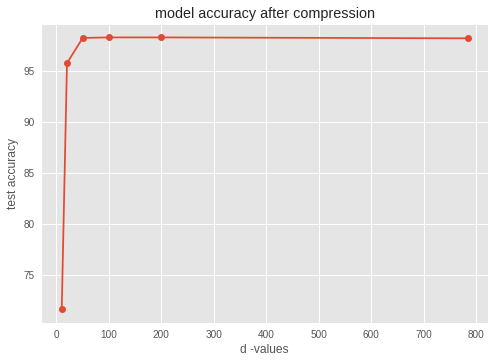

In [19]:
plt.plot(x_values, accuracies,marker='o')
plt.xlabel("d -values")
plt.ylabel("test accuracy")
plt.title("model accuracy after compression")

## Part A

In [0]:
fixed_D = 20

In [0]:
class CompresesedNet(nn.Module):
  def __init__(self, u1,v1,u2,v2,u3,v3,u4,v4,u5,v5):
    super(CompresesedNet,self).__init__()
    
    ## Define NN - 5 hidden layers 1024 hidden units
    self.fc6 = nn.Linear(1024, 10)
    
    # Layer 1
    self.u1 =  torch.nn.Parameter(u1,requires_grad=True)
    self.v1 =  torch.nn.Parameter(v1,requires_grad=True)
    
    self.bias1 = torch.nn.Parameter(torch.randn(1024),requires_grad=True)

    
    
    # Layer 2
    self.u2 = torch.nn.Parameter(u2,requires_grad=True)
    self.v2 = torch.nn.Parameter(v2,requires_grad=True)
    self.bias2 = torch.nn.Parameter(torch.randn(1024),requires_grad=True)
     
    
    
    # Layer 3
    self.u3 = torch.nn.Parameter(u3,requires_grad=True)
    self.v3 = torch.nn.Parameter(v3,requires_grad=True)
    self.bias3 = torch.nn.Parameter(torch.randn(1024),requires_grad=True)
    
    # Layer 4
    self.u4 = torch.nn.Parameter(u4,requires_grad=True)
    self.v4 = torch.nn.Parameter(v4,requires_grad=True)
    self.bias4 = torch.nn.Parameter(torch.randn(1024),requires_grad=True)
    
    # Layer 5
    self.u5 = torch.nn.Parameter(u5,requires_grad=True)
    self.v5 = torch.nn.Parameter(v5,requires_grad=True)
    self.bias5 = torch.nn.Parameter(torch.randn(1024),requires_grad=True)
    
  
  def forward(self,x):
    ## flat input features
    x = x.view(-1, self.num_flat_features(x))
    
    #layer 1
     
    x = torch.add(self.bias1, torch.mm(x,torch.mm(self.u1,self.v1).t()))
     
    x = F.relu(x)
    
    #layer 2
    x =  torch.add(torch.mm(x,torch.mm(self.u2,self.v2).t()) , self.bias2)
    x = F.relu(x)
    
    #layer 3
    x = torch.add(torch.mm(x,torch.mm(self.u3,self.v3).t()), self.bias3)
    x = F.relu(x)
    
    #layer 4
    x = torch.add(torch.mm(x,torch.mm(self.u4,self.v4).t()) , self.bias4)
    x = F.relu(x)
    
    #layer 5
    x = torch.add(torch.mm(x,torch.mm(self.u5,self.v5).t()) , self.bias5)
    x = F.relu(x)
    
    x = self.fc6(x)
    
    return F.log_softmax(x, dim=1)  
  
  def num_flat_features(self,x):
    size = x.size()[1:] # all dimensions except the batch dimension
    num_features = 1
    for s in size:
      num_features *=s
    return num_features
  
 

Initialize the weight matrices W(l) of a NEW network with the SVD factorization U(l)
:;1:D

V (l)
>
:;1:D
you learned in P1.5, where I combined S(l)
1:D;1:DV (l)>
:;1:D into a new matrix

V (l)
>
:;1:D. Note that
you don't replace W(l) with the approximated matrix cW
(l)
. Instead, you have to specically use
two variables U(l)
:;1:D and

V (l)
>
:;1:D in your implementation as a new pair of parameter matrices.
If you stop here, you'll get the same test performance as in P1.5. You can netune this network
though. Now this new network has new parameters to update, i.e. U(l)
:;1:D and

V (l)
>
:;1:D (as well
as the bias terms). Update them using BP. Since you initialized the new parameters with SVD,
which is a pretty good starting point, you may want to use a smaller-than-usual learning rate. In
this training job, you never use W(l), but work on the compressed net with U(l)
:;1:D and V (l)
:;1:D as
its parameters.

In [0]:
## initialize weights
U1, S1, V1 = svd(layer1_Weights)
U2, S2, V2 = svd(layer2_Weights)
U3, S3, V3 = svd(layer3_Weights)
U4, S4, V4 = svd(layer4_Weights)
U5, S5, V5 = svd(layer5_Weights)

U1, V11 = U1[:,:fixed_D], torch.mm(S1[:fixed_D].diag(), V1[:,:fixed_D].t())
U2 , V22 = U2[:,:fixed_D], torch.mm(S2[:fixed_D].diag(), V2[:,:fixed_D].t())
U3 , V33 = U3[:,:fixed_D], torch.mm(S3[:fixed_D].diag(), V3[:,:fixed_D].t())
U4 , V44 = U4[:,:fixed_D], torch.mm(S4[:fixed_D].diag(), V4[:,:fixed_D].t())
U5 , V55 = U5[:,:fixed_D], torch.mm(S5[:fixed_D].diag(), V5[:,:fixed_D].t())



model2 = CompresesedNet(U1,V11,U2,V22,U3, V33, U4, V44,U5,V55)
if is_cuda:
  model2 = model2.to(device)

In [101]:
## Train

model2.train()
train_acc_2 = []
train_loss_2 = []
def build_model2(model, criterion, optimizer,num_epochs):
  for step in range(num_epochs):
    
    accuracy, loss, images = train(model, criterion, optimizer) 
    train_acc_2.append(accuracy)
    train_loss_2.append(loss)
    
    if (step+1) % 2 == 0:
      print ('Step [{}/{}], Loss: {:.4f}, Acc: {:.2f}'.format(step+1, num_epochs, loss, accuracy))

      # 1. Log scalar values (scalar summary)
      info = { 'loss': loss, 'accuracy': accuracy }

      for tag, value in info.items():
          logger.scalar_summary(tag, value, step+1)

      # 2. Log values and gradients of the parameters (histogram summary)
      for tag, value in model.named_parameters():
        tag = tag.replace('.', '/')
        logger.histo_summary(tag, value.data.cpu().numpy(), step+1)
        logger.histo_summary(tag+'/grad', value.grad.data.cpu().numpy(), step+1)

optimizer2 = torch.optim.Adam(model2.parameters(), lr=0.00001)

build_model2(model2,criterion, optimizer2,num_epochs)



Step [2/10], Loss: 0.0468, Acc: 0.99
Step [4/10], Loss: 0.0430, Acc: 0.99
Step [6/10], Loss: 0.0399, Acc: 0.99
Step [8/10], Loss: 0.0372, Acc: 0.99
Step [10/10], Loss: 0.0347, Acc: 0.99


### Compressed Network

Text(0.5, 1.0, 'Compressed MNIST Train accuracy')

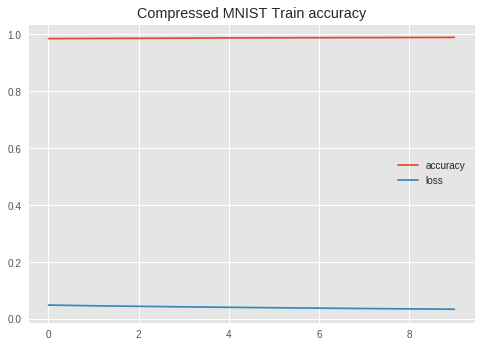

In [102]:
import numpy as np
plt.plot(np.arange(num_epochs), train_acc_2)
plt.plot(np.arange(num_epochs),train_loss_2)
plt.legend(["accuracy","loss"])
plt.title("Compressed MNIST Train accuracy")

###  6 a) Test the compressed Network

In [103]:
model2.eval()
with torch.no_grad():
    correct = 0
    total = 0
    batch_correct = 0
    test_accuracy = RunningAverage()
    for step, (images, labels) in enumerate(test_loader):
        batch_correct = 0
        images = images.to(device)
        labels = labels.to(device)
        
        outputs = model2(images)
        values, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        batch_correct += (predicted == labels).sum().item()
                
        correct+=batch_correct
        # 1. Log scalar values (scalar summary)
        info = {'accuracy': batch_correct }
        
        for tag, value in info.items():
          logger.scalar_summary(tag, value, step+1)
        
        # 2. Log test images (image summary)
        info = { 'test_predictions_images': images.view(-1, 28, 28)[:1000].cpu().numpy() }
        
        for tag, images in info.items():
          logger.image_summary(tag, images, step+1)
          
        #liveloss_test.update({
        #'test accuracy': (100 * correct / total),
        #})
        test_accuracy.update(batch_correct/labels.size(0))
    #liveloss_test.draw()
     
    print('Accuracy of the network on the 10000 test images: {} %'.format(100*test_accuracy()))

Accuracy of the network on the 10000 test images: 98.01226265822784 %


## Part b

Another technique you can use is to keep W(l)
as your parameter to update. Instead, you do SVD
at every iteration and make sure the feedforward pass always uses Wc
(l)
= U
(l)
:,1:DS
(l)
1:D,1:DV
(l)>
:,1:D.
What that means for the training algorithm is that you should think of the SVD procedure as
an approximation function W(l) ≈ f(W(l)
) = U
(l)
:,1:DS
(l)
1:D,1:DV
(l)>
:,1:D and the update for W(l)
involves the derivative f
0
(W(l)
) due to the chain rule (See M6 S15 where I explained this in the
quantization context). You can na¨ıvely assume an identity here f
0
(x) = x to streamline your BP.
By doing so, you can feedforward using Wc
(l)
while the updates are done on W(l)
. As the feedforward is always using the SVD’ed version of the weights, the network is aware of the additional
error introduced by the compression and can deal with it during training. The implementation of
this technique could be tricky, because now you need to define a custom derivative of this SVD
approximation function f(·) (an identity function). Both TF and PT give you this option. Take
a look at these articles:


In [0]:
## Extend PyTorch Autograd

class LinearFunction(torch.autograd.Function):
  
  @staticmethod
  def forward(ctx, input, weight, bias=None):
    ctx.save_for_backward(input,weight,bias)
    
    ## Perform svd
    u, s, v = svd(weight)
    new_weight = get_d_w_matrix(u, s, v,fixed_D)
    
    output = input.mm(new_weight.t())
    if bias is not None:
      output+=bias.unsqueeze(0).expand_as(output)
    return output
  
  @staticmethod
  def backward(ctx,grad_output):
    input, weight, bias = ctx.saved_tensors
    grad_input = grad_weight = grad_bias = None
    
    if ctx.needs_input_grad[0]:
      grad_input = grad_output.mm(weight)
    
    if ctx.needs_input_grad[1]:
      grad_weight = grad_output.t().mm(input)
      
    if bias is not None and ctx.needs_input_grad[2]:
      grad_bias = grad_output.sum(0).squeeze(0)
    
    return grad_input, grad_weight, grad_bias
      
    

In [120]:
class CompressedNet2(nn.Module):
  def __init__(self):
    super(CompressedNet2,self).__init__()
    
    ## Define NN - 5 hidden layers 1024 hidden units
    self.fc6 = nn.Linear(1024, 10)
    
    
    # Layer 1
    self.weights1 =  torch.nn.Parameter(torch.randn(1024, 784),requires_grad=True)
    self.bias1 = torch.nn.Parameter(torch.randn(1024),requires_grad=True)

    
    
    # Layer 2
    self.weights2 =  torch.nn.Parameter(torch.randn(1024, 1024),requires_grad=True)
    self.bias2 = torch.nn.Parameter(torch.randn(1024),requires_grad=True)
     
    
    
    # Layer 3
    self.weights3 =  torch.nn.Parameter(torch.randn(1024, 1024),requires_grad=True)
    self.bias3 = torch.nn.Parameter(torch.randn(1024),requires_grad=True)
    
    # Layer 4
    self.weights4 =  torch.nn.Parameter(torch.randn(1024, 1024),requires_grad=True)
    self.bias4 = torch.nn.Parameter(torch.randn(1024),requires_grad=True)
    
    # Layer 5
    self.weights5 =  torch.nn.Parameter(torch.randn(1024, 1024),requires_grad=True)
    self.bias5 = torch.nn.Parameter(torch.randn(1024),requires_grad=True)
    
  
  def forward(self,x):
    ## flat input features
    x = x.view(-1, self.num_flat_features(x))
    x = F.relu(LinearFunction.apply(x,self.weights1,self.bias1))
    x = F.relu(LinearFunction.apply(x,self.weights2,self.bias2))
    x = F.relu(LinearFunction.apply(x,self.weights3,self.bias3))
    x = F.relu(LinearFunction.apply(x,self.weights4,self.bias4))
    x = F.relu(LinearFunction.apply(x,self.weights5,self.bias5))
    x = self.fc6(x)
    
    return F.log_softmax(x, dim=1)  
  
  def num_flat_features(self,x):
    size = x.size()[1:] # all dimensions except the batch dimension
    num_features = 1
    for s in size:
      num_features *=s
    return num_features
    
    
model3 = CompressedNet2()
if is_cuda:
    model3.cuda()
    
## 5 hidden layers 
print(model3)

CompressedNet2(
  (fc6): Linear(in_features=1024, out_features=10, bias=True)
)


In [0]:
model3.train()
train_acc_3 = []
train_loss_3= []
def build_model3(model, criterion, optimizer,num_epochs):
  for step in range(num_epochs):
    
    accuracy, loss, images = train(model, criterion, optimizer) 
    train_acc_3.append(accuracy)
    train_loss_3.append(loss)
    
    if (step+1) % 2 == 0:
      print ('Step [{}/{}], Loss: {:.4f}, Acc: {:.2f}'.format(step+1, num_epochs, loss, accuracy))

      # 1. Log scalar values (scalar summary)
      info = { 'loss': loss, 'accuracy': accuracy }

      for tag, value in info.items():
          logger.scalar_summary(tag, value, step+1)

      # 2. Log values and gradients of the parameters (histogram summary)
      for tag, value in model.named_parameters():
        tag = tag.replace('.', '/')
        logger.histo_summary(tag, value.data.cpu().numpy(), step+1)
        logger.histo_summary(tag+'/grad', value.grad.data.cpu().numpy(), step+1)

optimizer3 = torch.optim.Adam(model3.parameters(), lr=0.00001)
build_model3(model3,criterion, optimizer3,num_epochs)


Step [2/10], Loss: 1175.0618, Acc: 0.19


In [110]:
list(model.named_parameters())[2][1].shape

torch.Size([1024, 1024])

### Test

In [0]:
model3.eval()
with torch.no_grad():
    correct = 0
    total = 0
    batch_correct = 0
    test_accuracy = RunningAverage()
    for step, (images, labels) in enumerate(test_loader):
        batch_correct = 0
        images = images.to(device)
        labels = labels.to(device)
        
        outputs = model3(images)
        values, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        batch_correct += (predicted == labels).sum().item()
                
        correct+=batch_correct
        # 1. Log scalar values (scalar summary)
        info = {'accuracy': batch_correct }
        
        for tag, value in info.items():
          logger.scalar_summary(tag, value, step+1)
        
        # 2. Log test images (image summary)
        info = { 'test_predictions_images': images.view(-1, 28, 28)[:1000].cpu().numpy() }
        
        for tag, images in info.items():
          logger.image_summary(tag, images, step+1)
          
     
        test_accuracy.update(batch_correct/labels.size(0))
    
     
    print('Accuracy of the network on the 10000 test images: {} %'.format(100*test_accuracy()))